In [81]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
figsize=(14, 4.5)

from util import util
import numpy as np
import os
from sklearn.metrics import accuracy_score
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constrained ML via Inference-Time Projection

It's never too late to quit violating constraints

## From Data Projection

**Let's consider again our data projection approach**

First we project the training data:

$$
z^* = \mathop{\rm argmin}_{z} \{ L(z, y) \mid g(z) \leq 0 \}
$$

...Then we train a supervised learning model as usual:

$$
\theta^* = \mathop{\rm argmin}_{\theta} \{ L(\hat{y}, z^*) \mid \hat{y} = f(x; \theta) \}
$$

**By doing this, we push the model towards learning the constraints**

...But we do it by decomposing the original problem

* This leads to some significant advantages (mainly flexibility)
* ...And a few disadvantages (e.g. less precise approximation)

## ...To Inference-Time Projection

**What if we swapped the two steps?**

We could start by trainingn a model as usual:

$$
\theta^* = \mathop{\rm argmin}_{\theta} \{ L(\hat{y}, y) \mid \hat{y} = f(x; \theta) \}
$$

...And then _projecting the predictions_:

$$
\hat{z} = \mathop{\rm argmin}_{z} \{ L(z, f(x; \theta^*)) \mid g(z) \leq 0 \}
$$

* We still perform projetion in the output space
* ...But in this case we do it at _inference-time_

**For this reason, we'll call this approach _inference-time projection_**

## Probabilistic Semantic

**As for data projection, when $L$ represents a likelihood**

...We can see the projection process process as MAP computation:

$$
\hat{z} = \mathop{\rm argmin}_{z} \{ L(z, f(x; \theta^*)) \mid g(z) \leq 0 \}
$$

* We seek a feasible vector $\hat{z}$
* ...That has the _largest estimated probability_ w.r.t. the predictions

**This trick is _extensively_ used in ML!**

* Rounding in binary classification is a form of projection
* ...And the same goes for the $\rm argmax$ used in multiclass classification

<div class=big>
    Let's start to study in detail this approach
</div>

## Two is Complicated, Three is a Crisis

**To begin with, our original does not really work**

$$
\hat{z} = \mathop{\rm argmin}_{z} \{ L(z, f(x; \theta^*)) \mid g(z) \leq 0 \}
$$

This projection problem is well defined _for the training data_

* However, since we are projecting at inference time
* ...We'll need to do it for _unseen examples_ as well

**Unseen examples might not come in batches**

...And even when they do, they may not be representative samples

* So, it's hard to deal with _relational constraints_ and _distribution constraints_
* In most cases, we'll be projecting _one example at a time_

...Though there are exceptions to this rule

## Where did the Input Go?

**All our constraint formulations so far make no mention of the input**

For example, in our projection problem

$$
\hat{z} = \mathop{\rm argmin}_{z} \{ L(z, f(x; \theta^*)) \mid g(z) \leq 0 \}
$$

...The constraint function $g(x)$ is defined on the output space alone

**When working with the training data, this is totally fine**

* It's quite frequent for the input to have an impact on the constraint
* ...But the input is _fixed_ at training time
* ...And therefore we can include its effect in the definition of $g$

## Where did the Input Go?

**On unseen examples, this is no longer the case**

...And we need to account for the input explicitly:

$$
\hat{z}(x) = \mathop{\rm argmin}_{z} \{ L(z, f(x; \theta^*)) \mid g(x, z) \leq 0 \}
$$

Formally:

* The projection $\hat{z}$ will be always input-dependent
* The constraint function $g(x, y)$ will be input-depended in general

**In practice, this isn't a big change**

* We'll need to build our constraints based on the value of $x$
* ...And then we can solve the projection problem as usual

## Computational Effort

**The computational effort for our projection operator**

$$
\hat{z}(x) = \mathop{\rm argmin}_{z} \{ L(z, f(x; \theta^*)) \mid g(x, z) \leq 0 \}
$$

...Is similar to the one we had for data-projection

* The fact that we typically project individual examples is good news
* ...Since it makes our problems _smaller_ and _simpler_

**However, there are cases when even this can be an issue**

Some applications (e.g. control systems) require very low latencey

* In this case, we might not have time enough to project

Some hardware has trouble with projection

* E.g. no optimization packages or not enough power on cyber-physical systems

## The Bad, the Ugly, and the Good

**So far, we've focused on the issues of this approach**

* It's hard to deal with many examples, which is bad
* There's a non-trivial computation step at inference time, which is ugly

So, why should we use inference-time projection at all?

> Three words.<br>**Guaranteed Constraint Satisfaction**


...And it holds also out-of-distribution!

* In some cases this can be _a massive advantage_
* Inference time projection is _the simplest method_ to achieve it

<div class=big>
    Let's consider a simple case study for inference-time projection
</div>

## Mutually Exclusive Classes

**Let's consider a _multilabel classification_ problem**

* Given an input sample
* ...We need to assign to it zero-to-$k$ classes

**The problem arises in a number of settings**

* Assigning tags to posts, or items in a marketplace
* Estimating properties of materials
* Identifying the favorite music/movie genres for a user
* ...

**We can build individual classifiers for each class**

...But using a single model for them all allows to exploit _correlations_

## Yeast Traits

**We'll focus on estimating genetic traits of yeast cells**

<center>
    <img src="assets/yeast.jpg" width=35%>
</center>

* Given numeric data from a [micro-array analysis](https://en.wikipedia.org/wiki/Microarray)
* ...We want to estimate the characteristic of a given yeast

## Loading the Data

**Let's load our dataset**

...Which comes fom the [Multi-label Classification Dataset Repository](https://www.uco.es/kdis/mllresources/)

In [85]:
fname = os.path.join('..', 'data', 'Yeast.arff')
X_tr, X_ts, y_tr, y_ts = util.load_multilabel_dataset(fname, label_num=14, standardize=True, test_fraction=0.2, seed=42)
display(y_tr.head())

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10,Class11,Class12,Class13,Class14
1681,0,1,1,1,0,0,0,0,0,1,1,1,1,0
1565,1,1,0,0,0,1,1,0,0,0,0,1,1,0
544,0,1,1,1,1,1,0,0,0,0,0,0,0,0
1517,0,0,0,0,0,0,1,1,0,0,0,1,1,0
821,1,1,0,0,0,0,0,0,0,0,0,1,1,0


* All inputs are numeric
* ...And we have 14 possible classes

## Unconstrained Model

**We'll start by training an unconstrained model**

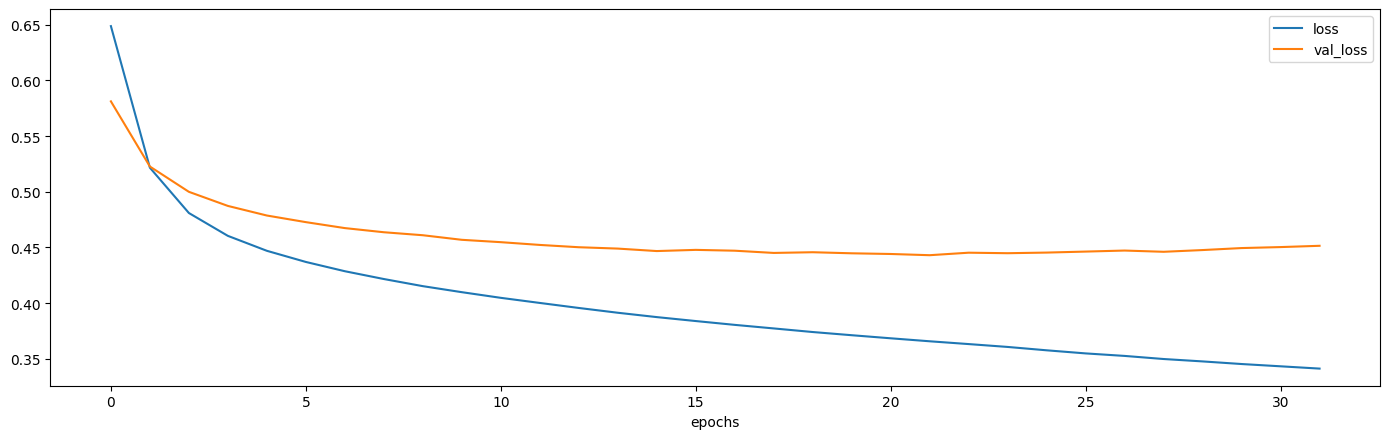

Model loss: 0.3658 (training) 0.4431 (validation)


In [86]:
nn0 = util.build_ml_model(input_size=X_tr.shape[1], output_size=y_tr.shape[1], hidden=[32], output_activation='sigmoid', name='baseline')
history = util.train_ml_model(nn0, X_tr, y_tr, epochs=200, validation_split=0.1, loss='binary_crossentropy')
util.plot_training_history(history, figsize=figsize)

## Accuracy Evaluation

**We can evaluated the model in terms of per-class accuracy**

Average class accuracy: 0.802 (test)


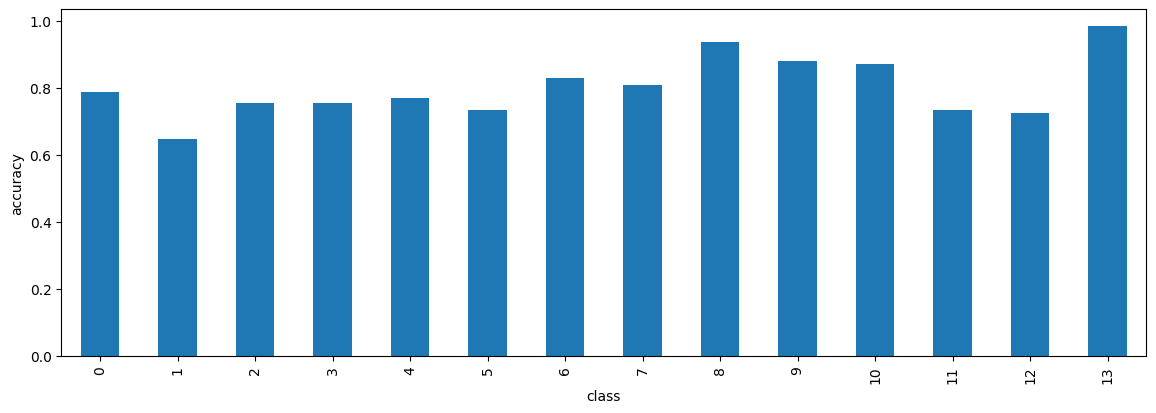

In [87]:
p_ts = nn0.predict(X_ts, verbose=0)
c_ts = np.round(p_ts)
ts_acc = util.get_multi_label_accuracy(y_ts, c_ts, series_name='original')
ts_acc.plot.bar(figsize=figsize, xlabel='class', ylabel='accuracy');
print(f'Average class accuracy: {ts_acc.mean():.3f} (test)')

## Mutually Exclusive Classes

**We will assume that certaint traits cannot occur together**

...Meaning that certain classes are mutually exclusive

* In this case, the constraint is just a purely synthetic example
* In the real world, contraints may come from regulation, domain knowledge, etc.

**We will treat as mutually exclusive all pairs of classes**

...That have a low-enough rate of co-occurrence _in the entire dataset_

In [88]:
all_y = pd.concat((y_tr, y_ts))
forbidden = util.get_forbidden_pairs(all_y, cutoff_quantile=0.5)
print(forbidden)

{(4, 9), (3, 7), (4, 6), (12, 13), (3, 10), (5, 13), (3, 13), (5, 10), (8, 9), (8, 12), (1, 6), (0, 8), (2, 5), (2, 8), (7, 10), (6, 8), (7, 13), (3, 9), (4, 8), (3, 6), (5, 9), (8, 11), (0, 7), (0, 4), (0, 10), (2, 7), (9, 13), (0, 13), (2, 10), (1, 8), (11, 13), (2, 13), (7, 9), (6, 13), (6, 10), (3, 5), (4, 10), (3, 8), (4, 13), (5, 8), (0, 3), (0, 9), (8, 10), (10, 13), (0, 6), (8, 13), (1, 13), (2, 6), (6, 9)}


## Checking Violations

**We can check how often our constraints are violated on the test data**

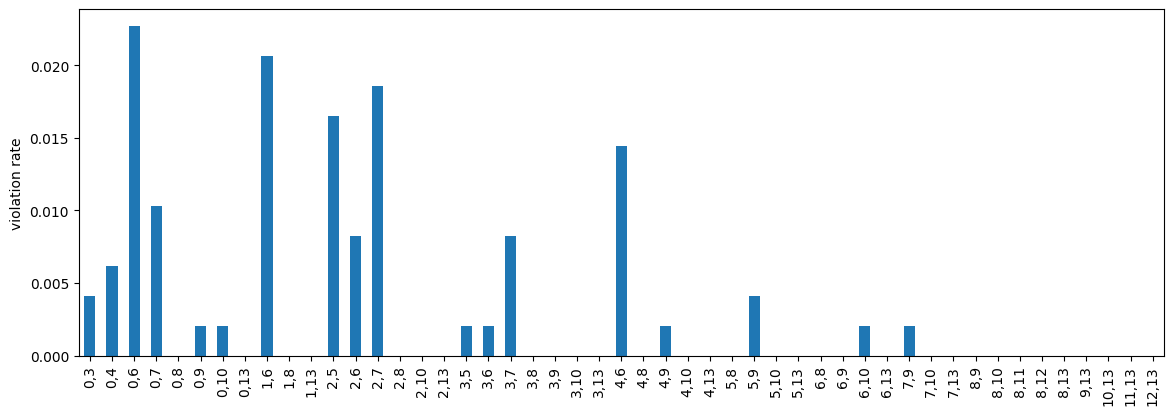

In [100]:
util.forbidden_pair_violation(c_ts, forbidden).plot.bar(figsize=figsize, ylabel='violation rate');

There some violation, though not many

## Projection Model

**We now need to define out projection problem:**

$$
\hat{z}(x) = \mathop{\rm argmin}_{z} \{ L(z, \hat{y}) \mid g(x, z) \leq 0 \} \quad \text{ with: } \hat{y} = f(x; \theta^*)
$$

For _pre-computed $\hat{y}$_, we'll need to obtain a declarative model of:

* The decision variables $z$
* The loss function $L(z, \hat{y})$
* The constraints $g(x, z) \leq 0$

**The decision variables represent a _vector of classes_**

$$
z_i \in \{0, 1\} \quad \text{ with } z_i = 1 \text{ iff we predict class $i$}
$$

## Projection Model

**We'l use the binary cross entropy as our loss function**

* The decision variables represent _actual classes_
* ...While the $\hat{y}$ contains estimated probabilities

**Hence, we can model the loss function as:**

$$
L(z, \hat{y}) = - \sum_{i=1}^k z_i \log (\hat{y}_i + \varepsilon) + (1 - z_i) \log (1 - \hat{y}_i + \varepsilon)
$$

* Since the cross-entropy is not well defined for $\hat{y}$ equal to 0 or 1
* ...We add a small constant to the logarithm

Overall, we have a _liner expression_ defined on $z$

## Projection Model

**The constraints state that certaint pairs of classes cannot occur together**

...Which can be modeled as:

$$
z_i + z_j \leq 1 \quad \forall (i, j) \in F
$$

* We consider all pairs of mutually exclusive classes
* ...And we allow at most one of the associated $z$ variables to be 1

**Overall, we have the following Mixed Integer Linear Program**

$$\begin{align}
\mathop{\rm argmin}_{z} & z^T \log (\hat{y} + \varepsilon) + (1-z)^T \log (1-\hat{y} + \varepsilon) \\
\text{subject to: } & z_i + z_j \leq 1 & \forall (j, j) \in F \\
& z_i \in \{0, 1\} & \forall i = 1..n_c
\end{align}$$

## Maximum Weight Indedendent Set

**What we are looking for is a [maximum weight independent set](https://en.wikipedia.org/wiki/Independent_set_(graph_theory))**

...On the graph defined by the mutually exclusive classes

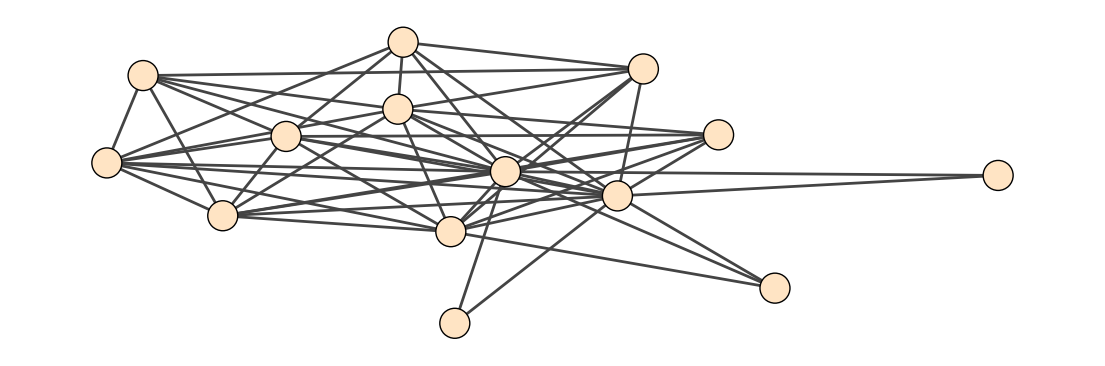

In [101]:
util.plot_forbidden_pairs(nclasses=y_tr.shape[1], forbidden=forbidden, figsize=figsize)

* This is an NP-hard problem, but _not a very difficult one_!

## Implementation

**An implementation of the model is available in the `util` module**

```python
def project_multilabel_classification(p, forbidden, solver='CBC', tlim=10):
    ...
    z = [slv.IntVar(0, 1, 'z_{c}') for c in range(label_num)]
    for c0, c1 in forbidden: # constraintes
        slv.Add(z[c0] + z[c1] <= 1)
    for ii in range(p.shape[0]):
        # Define the objective
        obj = - sum([z[c] * np.log(p[ii, c] + 1e-4) +
                     (1 - z[c])*np.log(1 - p[ii, c] + 1e-4)
                     for c in range(label_num)])
        slv.Minimize(obj)
        status = slv.Solve()
        ...
```

* For improved efficiency, we build _a single model_ to project multiple examples
* On each example, we just change the objective function

## Computing the Projections

**We can now compute the inference-time projections for the test set**

In [104]:
%time pc_ts = util.project_multilabel_classification(p_ts, forbidden=forbidden, tlim=10, solver='SCIP')
print(f'For {len(p_ts)} test examples')

CPU times: user 194 ms, sys: 31.6 ms, total: 225 ms
Wall time: 225 ms
For 484 test examples


* Even if the problem is technically intractable (NP-hard)
* ...The run time is _very low_!

**For roughly 10% of the example the projection results in a change:**

In [105]:
nc_ts = np.any(np.abs(pc_ts - c_ts) > 0, axis=1).sum()
print(f'Non-trivial projections: {nc_ts} (test)')

Non-trivial projections: 44 (test)


## Accuracy Evaluation

**We can compare the accuracy of the constrained model with the original one**

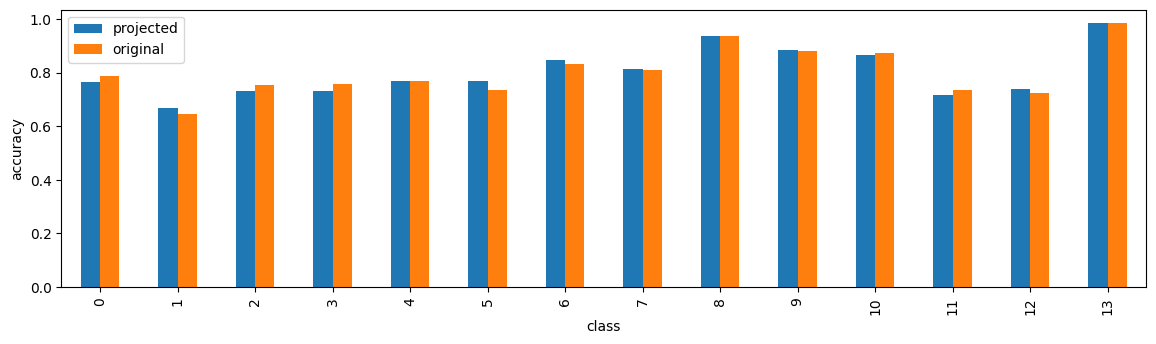

In [109]:
tmp = pd.concat([ts_acc_p, ts_acc], axis=1)
tmp.plot.bar(figsize=(figsize[0], figsize[1]*0.8), xlabel='class', ylabel='accuracy');

* For some classes, the constrained model works even better!
* This happens since the constraint encode some _information about unseen examples_

## Accuracy Evaluation

**Projection methods enable also a comparison _against an oracle_**

Which can be obtained by _projecting the ground truth labels_

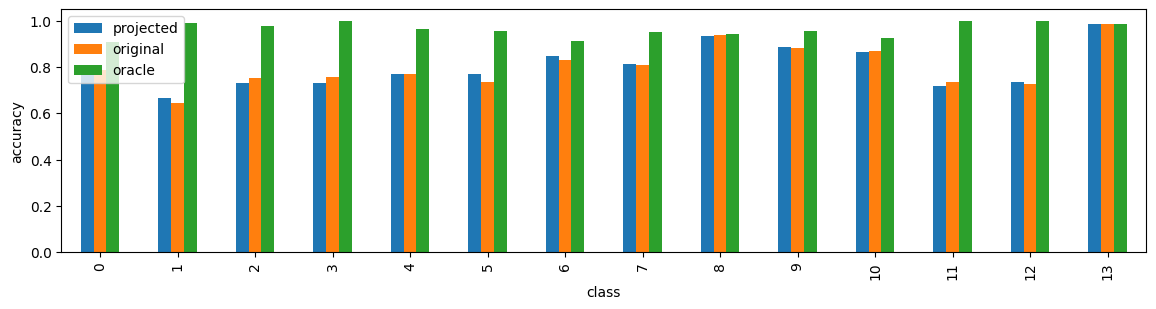

In [112]:
ts_acc_o = util.get_multi_label_accuracy(y_ts, oc_ts, series_name='oracle')
tmp = pd.concat([ts_acc_p, ts_acc, ts_acc_o], axis=1)
tmp.plot.bar(figsize=(figsize[0], figsize[1]*0.7), xlabel='class', ylabel='accuracy');

Doing this tells us _the best we can do_, accounting for the constraints